# Market position indicators using CFTC COTR 

We examine the CFTC **Commitment of Traders Reports (COTR)** for futures and options to derive indicators of market position among Asset/Money Managers. Our generalized formulation permits treating asset classes which include: gold, silver, US dollar, bonds, and equities.

Detailed explantory notes regarding the raw data can be found here:
http://www.cftc.gov/MarketReports/CommitmentsofTraders/ExplanatoryNotes We shall disregard the Legacy format, and focus on the data after 13 June 2006. Current data is released weekly on Fridays.

*Dependencies:*

    - Linux, bash [not crucial, cross-platform prefered]
    - Python: matplotlib, pandas [recommend Anaconda distribution]
    - Modules: fecon.py
     
*CHANGE LOG*

    2915-08-31  Simply use fecon.py to generally access various modules.
    2015-08-25  Update tpl to v4.15.0812. Add silver COTR,
                   and the class of precious metals w4cotr_metals.
    2015-08-09  Change of variable names for clarity.
    2015-08-07  First version arising as test of the Quandl API.

In [1]:
#  NOTEBOOK v4 settings and system details:      [00-tpl v4.15.0812]

#  Assume that the backend is LINUX (e.g. Ubuntu running bash shell):
print '\n ::  TIMESTAMP of last notebook execution:'
!date
print ' ::  IPython version:'
!ipython --version

#  Automatically RELOAD modified modules:
%load_ext autoreload
%autoreload 2
#           0 disables autoreload.

#  DISPLAY options
from IPython.display import Image 
#  e.g. Image(filename='holt-winters-equations.png', embed=True) # url= also works
from IPython.display import YouTubeVideo
#  e.g. YouTubeVideo('1j_HxD4iLn8', start='43', width=600, height=400)
from IPython.display import HTML # useful for snippets
#  e.g. HTML('<iframe src=http://en.mobile.wikipedia.org/?useformat=mobile width=700 height=350></iframe>')
from IPython.core import page
get_ipython().set_hook('show_in_pager', page.as_hook(page.display_page), 0)
#  Or equivalently in config file: "InteractiveShell.display_page = True", 
#  which will display results in secondary notebook pager frame in a cell.

#  MATH display, use %%latex, rather than the following:
#                from IPython.display import Math
#                from IPython.display import Latex
#  Generate PLOTS inside notebook:
%matplotlib inline

import pandas as pd
print ' ::  pandas version:'
print pd.__version__
#      pandas DataFrames are represented as text by default; enable HTML representation:
#      [Deprecated: pd.core.format.set_printoptions( notebook_repr_html=True ) ]
pd.set_option( 'display.notebook_repr_html', False )

print ' ::  Working directory (set as $workd):'
workd, = !pwd
print workd + '\n'


 ::  TIMESTAMP of last notebook execution:
Mon Aug 31 22:28:38 PDT 2015
 ::  IPython version:
3.2.1
 ::  pandas version:
0.16.2
 ::  Working directory (set as $workd):
/home/yaya/Dropbox/share/git/nous/fecon235/nb



In [2]:
from fecon import *

## COTR example: Gold

To get an idea of what's contained in a Commitment of Traders Report, we first look at an example from the commodity futures market. Financial futures have a different format since the notion of a "Producer" is not entirely appropriate (though dealers may produce derivatives which may rely on the futures market). 

The the latest data is downloaded via Quandl as a pandas dataframe. The relevant functions are found in the yi_quandl module.

In [3]:
#  We first focus on GOLD:
cotr = cotr_get( f4xau )
#                ^ = 'GC' currently.
#  Show column labels and only the last data point:
tail( cotr, 1 )
#  The entire dataset is actually in memory.

            Open Interest  Producer/Merchant/Processor/User Longs  \
Date                                                                
2015-08-25         661565                                   36280   

            Producer/Merchant/Processor/User Shorts  Swap Dealer Longs  \
Date                                                                     
2015-08-25                                   108621              75091   

            Swap Dealer Shorts  Swap Dealer Spreads  Money Manager Longs  \
Date                                                                       
2015-08-25               71124               139946               125505   

            Money Manager Shorts  Money Manager Spreads  \
Date                                                      
2015-08-25                 81234                  57366   

            Other Reportable Longs  Other Reportable Shorts  \
Date                                                          
2015-08-25                   67899  

### Notable points

- Number of longs = Number of shorts, by necessity -- and each side equals the *Open Interest*.
- Option positions are computed on a futures-equivalent basis using delta factors supplied by the exchanges.
- Generally non-directional traders (usually with hedged positions): Producer/User, Swap Dealer, and Dealer.
- Generally **directional traders**: *Money Manager* (commodities), Leveraged Funds and *Asset Manager* (financials). Leveraged Funds appear to take very choppy short-term positions, whereas Asset Manager will show a longer-term positional narrative.
- Non-directional trading by a Money Manager, Asset Manager, and Leveraged Funds is categorized separately under Spreads.
- "Non reportable" traders are small players trading contract sizes under CFTC reporting thresholds -- generally, noise traders categorized as speculators.
- **COTR is released weekly on Friday.**

### Parsing out positions

To characterize informed market direction we focus on the directional traders who are trading in large size which must be reported to the CFTC. Note that their *Longs* do not necessarily equal their *Shorts*" since the counter-parties may be other players in the market, e.g. hedged producers, spreaders, or small uninformed traders.

In [4]:
longs  = cotr['Money Manager Longs']
shorts = cotr['Money Manager Shorts']

In [5]:
# diff in number of contracts:
lsdiff = todf( longs - shorts )

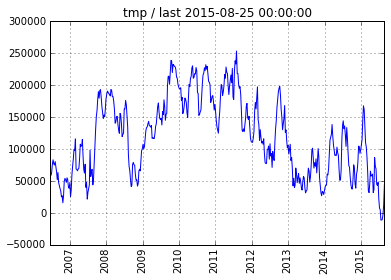

In [6]:
plot( lsdiff )

The preceding chart shows the difference between the number contracts long versus short. It is somewhat useful, but we would prefer a **scale-free [0, 1] measure** which reveal position: 0 for bearish, 0.50 for neutral, and 1 for bullish. This will also allow us later to combine readings to show position in a sector, for example, the US dollar versus foreign currencies.

In [7]:
#  Scale-free measure from zero to 1:
z_xau = todf( longs / (longs + shorts ))

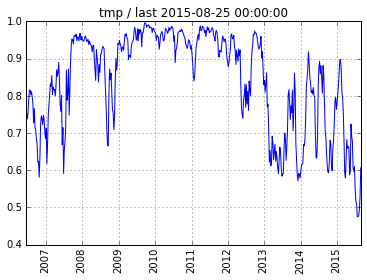

In [8]:
#  Interpret as prob( bullish Manager ):
plot( z_xau )

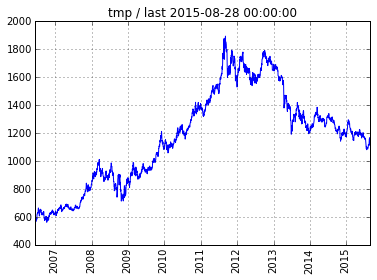

In [9]:
# How does our indicator compare to spot gold prices?
xau = get( d4xau )
plot( xau['2006-06-12':] )
# using the FRED database for Gold London PM fix.

GOLD: We can definitely see a "raging bull" in action through 2013 -- our indicator approaches 1.0 frequently! Thereafter, there are four major efforts to re-ignite the bull market through mid-2015, but without much success as the price creeps downward. July 2016 sees a breakdown below the 0.6 positional support, to under the 0.5 neutral mark -- which means more shorts than longs among managers. 

## Generalization to Asset Classes

###  This function will compute position for commodities and financials:


```
#  See yi_quandl.py for further details:

def cotr_position( futures='GC' ):
     '''Extract market position from CFTC Commitment of Traders Report.'''
     cotr = cotr_get( futures )
     #  Report for both futures and options requested by implicit "FO".
     #
     #  For directionality we use these categories:
     try:
          longs  = cotr['Asset Manager Longs']
          shorts = cotr['Asset Manager Shorts']
          #  "Leveraged Funds" for FINANCIALS appear short-term, whereas 
          #  "Asset Manager" takes longer term perspective.
     except:
          longs  = cotr['Money Manager Longs']
          shorts = cotr['Money Manager Shorts']
          #  "Money Manager" for COMMODITIES. 
          #  The report is structured differently than financials.
          #
     #                _Scale-free between 0 and 1 indicating bullishness.
     return tools.todf( longs / (longs + shorts ))
```

*Our scale-free measure on [0,1] has the advantage that comparable contracts can easily be averaged, and thus interpreted.*

## Precious metals

Let's first take a look at the COTR position for silver (spot symbol XAG). Graphically it is quite similar to gold, so we will also examine their statistical correlation.

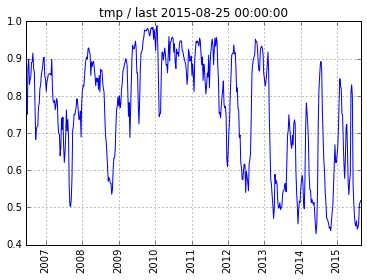

In [10]:
#  Silver position:
z_xag = cotr_position( f4xag )
plot( z_xag )

In [11]:
#  Correlation and regression:
#  stat2( z_xag['Y'], z_xau['Y'] )

COTR positions for gold and silver are very correlated (approximately 77%), but a linear regression model is not satisfactory. This means they each contain some information that the other lacks. But since the market sentiment regarding both are similar, it is useful to combine their signals as precious metals.

We use the futures and options COTR for contracts on both gold and silver, then average their position indicators. We can run this procedure by retrieval of a variable called w4cotr_metals (where w4 tells us that it's weekly series).

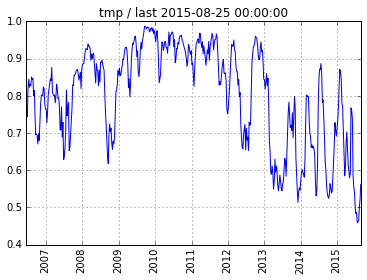

In [12]:
#  PRECIOUS METALS position:
z_metals = get( w4cotr_metals )
plot( z_metals )

Positions in the precious metals have recently exhibited swings characteristic of momentum trading. Worth noting is the August 2015 dip into net short region. Less erratic swings probably will indicate a trend in prices of the underlying metals. 

## US Dollar position

We use the futures and options COTR for contracts on both the euro and yen, then average their position indicators. To invert direction due to quotation style, we take the complement, i.e. (1-mean), so we still retain the [0,1] range. We can run this procedure by retrieval of a variable called *w4cotr_usd* (where w4 tells us that it's weekly series).

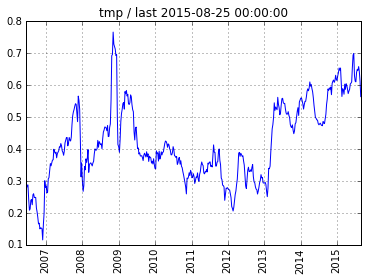

In [13]:
#  Dollar position:
z_usd = get( w4cotr_usd )
plot( z_usd )

As the subprime mortgage crisis deepened in the US, worldwide safety flight to USD peaks at our indicator exceeding 0.7,  Thereafter, we see an orderly decline through 2013 due to Fed's QE quantitative easing. A bull market develops due to the termination of QE by the Fed, while QE is relentlessly pursued by BoJ, and finally the ECB activates its own QE. The sudden acceleration at the beginning of 2013 was a huge early warning sign of change in market sentiment.

Next is the dollar index (against most currencies) used by the Federal Reserve Bank which considers the real trade balance RTB between countries:

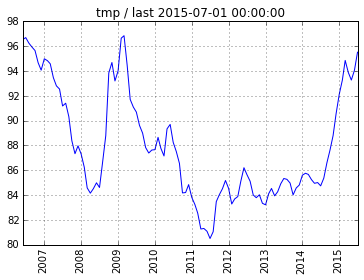

In [14]:
# Fed US Dollar index, m4 means monthly frequency:
usd = get( m4usdrtb )
plot( usd['2006-06-01':])

## Bonds position

We use the futures and options COTR for contracts on both the eurodollar (strips) and 10-year Treasury bond, then average their position indicators. We can run this procedure by retrieval of a variable called *w4cotr_bonds* (where w4 tells us that it's weekly series). 

The indicator intends to show market position across the active yield curve, not in terms of rates, but rather prices of fixed-income instruments. This is useful to gauge the effects of Fed policy.

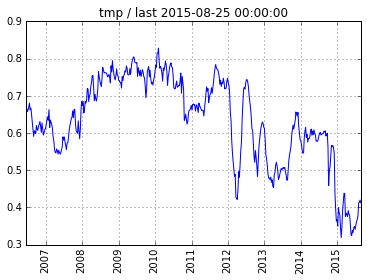

In [15]:
#  Bonds position:
z_bonds = get( w4cotr_bonds )
plot( z_bonds )

From the beginnings of the subprime mortgage crisis to 2012, there is a commonplacent bull market conviction that the Fed wants lower rates across the yield curve: bond rates fall from 5% to 1.5%. Thereafter, the market seeks to front-run the Fed in the event ZIRP Zero Interest Rate Policy is reversed, but is denied on several occassions. 

Only after 2015 does our indicator spend time below the neutral halfway mark: Fed has ended QE, and the market seeks to determine the time of the first rate hike since the Great Recession. Bottoming rates in 2012 and 2015 technically imply a floor around 1.8% for the 10-y Treasuries. 

Given favorable economic conditions, esp. unemployment, and the expected hike in September of 2015: a bear market is developing for bond valuations.

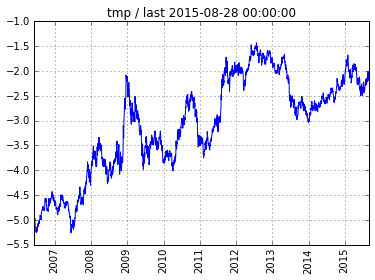

In [16]:
bondrate = get( d4bond10 )
#  10-y Treasury rate INVERTED in lieu of price:
plot( -bondrate['2006-06-01':] )

## Equities position

We use the futures and options COTR for contracts on both the S&P 500 and and its e-mini version, then average their position indicators. We can run this procedure by retrieval of a variable called *w4cotr_equities* (where w4 tells us that it's weekly series). 

It is worth noting that our position indicator is extremely bullish going into the Great Recession, however, even during the worst sell-offs in equities the indicator never goes into bear territory. We suspect this is because many asset managers are constrained to going net long. 

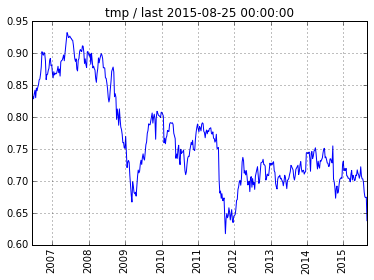

In [17]:
#  Equities position:
z_eq = get( w4cotr_equities )
plot( z_eq  )

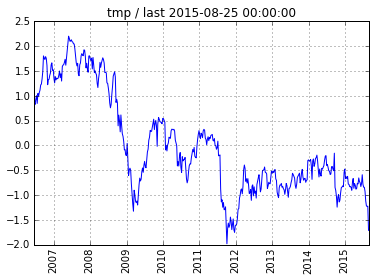

In [18]:
#  So let's normalize the equities indicator:
plot(normalize( z_eq ))

2015-08-08: Given our data, the neutral mark is around 0.77 for equities position. Normalization shows we are currently over 1 standard deviation into bear territory, even though the market seems to make advances upward every day.

 ::  S&P 500 prepend successfully goes back to 1957.


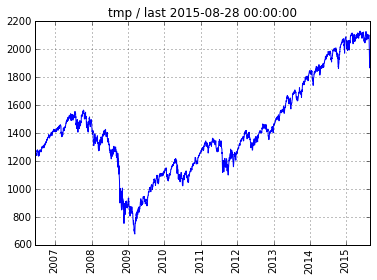

In [19]:
#  SPX price data showing the post-2009 equities bull market:
spx = get( d4spx )
plot( spx['2006-06-12':])

## Characterizing directionality

Without graphical aids, we wish to quantify directionality. Let's compute the geometric mean return over two years on the positions data (as opposed to the underlying prices). So here we are computing the *rate* at which market sentiment is rising or falling.

In [20]:
#  class consists of precious metals, US dollar, bonds, equities:
z_class = [ z_metals, z_usd, z_bonds, z_eq ]

In [21]:
#  Sketch of code:
for i in z_class:
    print georet( tail(i, 104), 52 )

[-17.17, -3.49, 52.31, 52]
[5.58, 8.21, 22.94, 52]
[-12.31, -5.8, 36.07, 52]
[-5.25, -4.64, 11.06, 52]


2015-08-08: Clearly market sentiment has the greatest variation in gold. Gold's directional reading of -14 is about the same magnitude as the US dollar, but opposite in sign as expected. The gold market is twice as bearish as the bond market, but almost five times as bearish as the equities market. 

## Current position relative to history

We saw that our position indicator may not entirely span the [0,1] as expected due to institutional reasons (see the equities case above). So we can normalize a given series, and then look at the last point to gauge current market position.

In [22]:
for i in z_class:
    print tailvalue(normalize( i ))

-1.78818270716
1.18495247017
-1.87504049989
-1.71051222402


## Correlation among position indicators

Note that this is quite different than the usual look at price correlations -- it would be more akin to seeing how trader sentiment correlates across asset classes.

In [23]:
z_data = paste( z_class )
z_data.columns = ['z_metals', 'z_usd', 'z_bonds', 'z_eq']

In [24]:
stats( z_data )

         z_metals       z_usd     z_bonds        z_eq
count  481.000000  481.000000  481.000000  481.000000
mean     0.801825    0.418995    0.633102    0.766572
std      0.133681    0.122698    0.117527    0.075324
min      0.458814    0.115009    0.318970    0.617309
25%      0.700121    0.329470    0.566703    0.708683
50%      0.834483    0.391493    0.642794    0.743193
75%      0.917903    0.518659    0.736328    0.822280
max      0.986663    0.766730    0.828573    0.932568

 ::  Index on min:
z_metals   2015-07-21
z_usd      2006-11-28
z_bonds    2015-02-10
z_eq       2011-10-04
dtype: datetime64[ns]

 ::  Index on max:
z_metals   2009-09-15
z_usd      2008-11-04
z_bonds    2010-02-02
z_eq       2007-05-29
dtype: datetime64[ns]

 ::  Head:
            z_metals     z_usd   z_bonds      z_eq
Date                                              
2006-06-13  0.780357  0.281513  0.647033  0.822280
2006-06-20  0.753881  0.278856  0.666125  0.831975
2006-06-27  0.744485  0.286700  0.6581

No strong correlations among position indicators. As expected z_metals and z_usd are negatively correlated, but precious metals sentiment is most correlated to bonds. We have closely examined the relationship between gold and interest rates in another notebook, and indeed, *real rates* are very significant. Our bond indicator, however, only relates to nominal rates.

In general, we hope that the position indicators are *not* correlated too closely with the underlying prices because we are seeking information which is not derivable from observable prices. It is most interesting when market positions *diverge* from identified patterns in price charts.